<a href="https://colab.research.google.com/github/superbunny38/2021DeepLearning/blob/main/pytorch/Chap_7_(1)_Style_Transfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Neural Style Transfer
Style Transfer 알고리즘은 콘텐츠 이미지(C)와 스타일 이미지(S)가 주어지면, 주어진 이미지의 내용과 스타일을 갖는 새로운 이미지(O)를 만들어 낸다.

CNN의 초기 레이어: 매우 일반적인 정보 학습(직선, 곡선 등)
CNN의 마지막 레이어: 고수준의 개념 캡처(눈, 건물, 나무 등)

MSE(C,O)
MSE(S,O)

gram matrix: 다중 레이어에 걸쳐 캡처된 특징 지도 간의 상관 관계를 계산한 후 스타일 계산에 대한 특정치를 제공.(비슷한 스타일 = 비슷한 gram matrix)

In [1]:
import os
from torch.utils.data import Dataset,DataLoader
import torch
from torch import nn
from torch.autograd import Variable
from torchvision.datasets import MNIST
from torchvision import datasets, transforms
from torchvision.utils import save_image
import torch.optim as optim
import numpy as np
import pandas as pd
import torch.nn.parallel
import torch.optim as optim
import torch.utils.data

## 데이터 로딩하기

In [2]:
image_size = 512
is_cuda = torch.cuda.is_available()
#필요한 모든 전처리를 수행하며 정규화를 위해 VGG 모델이 사용한 것과 동일한 값 사용
preprocessing = transforms.Compose([transforms.Resize(image_size),
                           transforms.ToTensor(),
                           transforms.Lambda(lambda x: x[torch.LongTensor([2,1,0])]), 
                           transforms.Normalize(mean=[0.40760392, 0.45795686, 0.48501961], 
                                                std=[1,1,1]),
                           transforms.Lambda(lambda x: x.mul_(255)),
                          ])
#모델의 출력을 원본 값으로 역정규화
processing = transforms.Compose([transforms.Lambda(lambda x: x.mul_(1./255)),
                           transforms.Normalize(mean=[-0.40760392, -0.45795686, -0.48501961], 
                                                std=[1,1,1]),
                           transforms.Lambda(lambda x: x[torch.LongTensor([2,1,0])]), 
                           ])

postprocess = transforms.Compose([transforms.ToPILImage()])

In [3]:
#1보다 큰 모든 값을 1로 제한, 0보다 작은 값은 0으로 제한
def postprocess_b(tensor): 
    t = processing(tensor)
    t[t>1] = 1    
    t[t<0] = 0
    img = postprocess(t)
    return img

In [4]:
from torchvision.models import vgg19
from torch.autograd import Variable
from collections import OrderedDict
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from PIL import Image
%pylab inline

Populating the interactive namespace from numpy and matplotlib


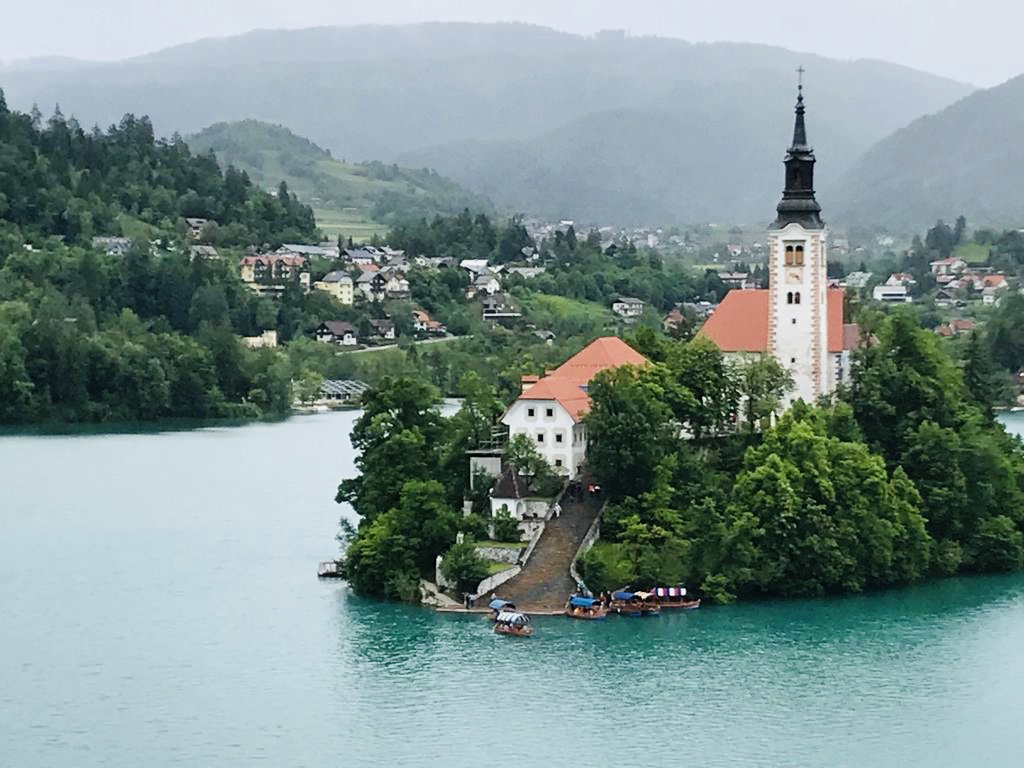

In [5]:
from IPython.display import Image 
Image('/content/content_image.jpg')

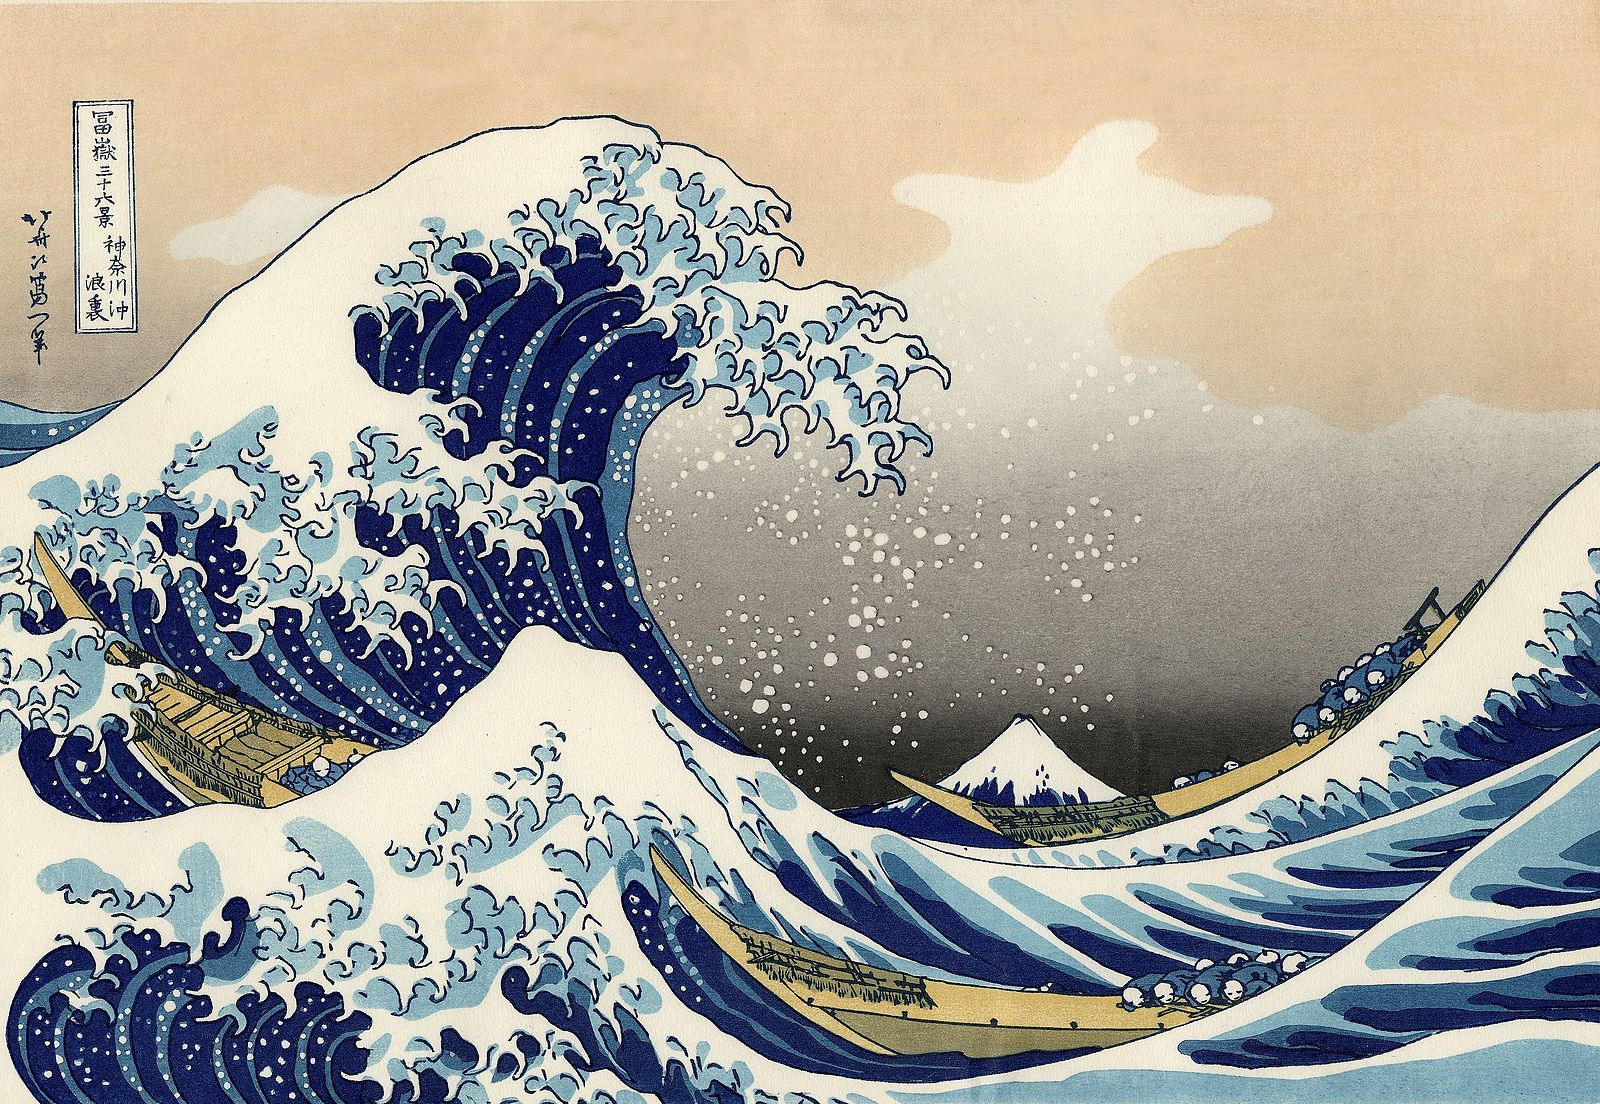

In [6]:
Image("/content/style_image.jpg")

In [7]:
#이미지를 ㄹ드하고 preprocessing으로 변형을 적용하여 variable 안으로 이미지를 변환
import PIL.Image
def loader(image_name):
  image = PIL.Image.open(image_name)
  image= Variable(preprocessing(image))
  #fake batch dimension required to fit network's input dimensions
  image = image.unsqueeze(0)
  return image

In [8]:
#스타일과 콘텐츠 이미지를 로드
from PIL import Image
%pylab inline
style_image = loader("/content/style_image.jpg")
content_image = loader("/content/content_image.jpg")

Populating the interactive namespace from numpy and matplotlib


In [9]:
style_image

tensor([[[[103.0610,  98.0610,  96.0610,  ...,  59.0610,  53.0610,  50.0610],
          [ 95.0610,  94.0610,  95.0610,  ...,  56.0610,  52.0610,  48.0610],
          [ 77.0610,  71.0610,  74.0610,  ...,  53.0610,  55.0610,  51.0610],
          ...,
          [108.0610, 107.0610, 111.0610,  ...,  72.0610,  78.0610,  89.0610],
          [107.0610, 108.0610, 109.0610,  ...,  69.0610,  66.0610,  76.0610],
          [107.0610, 109.0610, 107.0610,  ...,  78.0610,  83.0610,  95.0610]],

         [[117.2210, 112.2210, 110.2210,  ...,  85.2210,  80.2210,  77.2210],
          [110.2210, 108.2210, 110.2210,  ...,  82.2210,  79.2210,  75.2210],
          [ 94.2210,  88.2210,  91.2210,  ...,  78.2210,  81.2210,  78.2210],
          ...,
          [114.2210, 113.2210, 117.2210,  ...,  46.2210,  51.2210,  63.2210],
          [113.2210, 114.2210, 115.2210,  ...,  46.2210,  43.2210,  53.2210],
          [113.2210, 115.2210, 113.2210,  ...,  58.2210,  64.2210,  76.2210]],

         [[115.3200, 111.3200,

In [19]:
content_image

tensor([[[[134.0610, 134.0610, 134.0610,  ..., 133.0610, 133.0610, 133.0610],
          [134.0610, 134.0610, 134.0610,  ..., 133.0610, 133.0610, 133.0610],
          [134.0610, 134.0610, 134.0610,  ..., 133.0610, 133.0610, 133.0610],
          ...,
          [ 97.0610,  96.0610,  98.0610,  ..., 109.0610, 109.0610, 109.0610],
          [ 96.0610,  98.0610, 100.0610,  ..., 110.0610, 110.0610, 110.0610],
          [ 97.0610, 100.0610, 102.0610,  ..., 109.0610, 109.0610, 109.0610]],

         [[110.2210, 110.2210, 110.2210,  ..., 110.2210, 110.2210, 110.2210],
          [110.2210, 110.2210, 110.2210,  ..., 110.2210, 110.2210, 110.2210],
          [110.2210, 110.2210, 110.2210,  ..., 110.2210, 110.2210, 110.2210],
          ...,
          [ 77.2210,  76.2210,  78.2210,  ...,  89.2210,  89.2210,  89.2210],
          [ 76.2210,  78.2210,  80.2210,  ...,  90.2210,  90.2210,  90.2210],
          [ 77.2210,  80.2210,  82.2210,  ...,  89.2210,  89.2210,  89.2210]],

         [[ 95.3200,  95.3200,

In [20]:
len(style_image)

1

In [21]:
len(content_image)

1

In [22]:
len(style_image[0])

3

In [23]:
len(content_image[0])

3

In [10]:
style_image.size()

torch.Size([1, 3, 512, 742])

In [11]:
content_image.size()

torch.Size([1, 3, 512, 682])

In [12]:
#콘텐츠 이미지를 생성
output_image = Variable(content_image.data.clone(), requires_grad = True)

## VGG 모델 생성

In [13]:
vgg = vgg19(pretrained=True).features

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth


  0%|          | 0.00/548M [00:00<?, ?B/s]

In [14]:
vgg = vgg19(pretrained=True).features

for param in vgg.parameters():
    param.requires_grad = False
if is_cuda:
    style_image = style_image.cuda()
    content_image = content_image.cuda()
    vgg = vgg.cuda()

In [15]:
output_image = Variable(content_image.data.clone(),requires_grad=True)

In [16]:
style_layers = [1,6,11,20,25]
content_layers = [21]
loss_layers = style_layers + content_layers

Content Loss: 입력과 출력 이미지 사이의 거리

Style Loss: 각 특징 맵에 대해 생성된 gram matrix의 MSE(gram matrix: 특징의 상관관계 값을 나타냄)

In [17]:
#채널마다 모든 값을 평탄화한 다음 이것의 전치 값과 곱하여 상관관계를 찾음
class GramMatrix(nn.Module):
  
  def forward(self, input):
    b,c,h,w = input.size()
    features = input.view(b,c,h*w)#flatten
    gram_matrix = torch.bmm(features, features.transpose(1,2))#전치와 곱함(bmm: 행렬 곱)
    gram_matrix.div_(h*w)#정규화
    return gram_matrix

In [18]:
gr = GramMatrix()
gr.forward(style_image)

tensor([[[4991.3130, 5395.9604, 5290.5010],
         [5395.9604, 6555.5752, 6848.3325],
         [5290.5010, 6848.3325, 7530.9229]]], device='cuda:0')

In [19]:
class StyleLoss(nn.Module):
  def forward(self, inputs, targets):
    out = nn.MSELoss()(GramMatrix()(inputs),targets)
    return (out)

## 손실 추출하기

In [20]:
class LayerActivations():
  features = []

  def __init__(self, model, layer_numbers):#layer_numbers: 출력을 추출한 레이어 번호
    self.hooks = []
    for layer_num in layer_numbers:
      self.hooks.append(model[layer_num].register_forward_hook(self.hook_fn))#register_forward_hook: VGG로부터 중간 레이어의 출력을 추출

  def hook_fn(self, module, input, output):
    self.features.append(output)#출력을 캡처하여 feartures 배열에 저장함

  def remove(self):#출력을 캡처하고 싶지 않으면
    for hook in self.hooks:
      hook.remove()
'''
  def extract_layers():#필요한 출력을 추출
    la = LayerActivations(model, layers)
    la.fearures = []#앞선 실행의 출력 포함하지 않도록 초기화
    out = model(images)
    la.remove()#모델에 등록된 모든 hook 제거
    return la.features()
    '''

'\n  def extract_layers():#필요한 출력을 추출\n    la = LayerActivations(model, layers)\n    la.fearures = []#앞선 실행의 출력 포함하지 않도록 초기화\n    out = model(images)\n    la.remove()#모델에 등록된 모든 hook 제거\n    return la.features()\n    '

필요한 target을 추출하는 과정

In [21]:
style_layers = [1,6,11,20,25]
content_layers = [21]
loss_layers = style_layers + content_layers

In [22]:
def extract_layers(layers,img,model=None):
    la = LayerActivations(model,layers)
    #Clearing the cache 
    la.features = []
    out = model(img)
    la.remove()
    return la.features

In [23]:
#스타일 및 콘텐츠 이미지에 대해 필요한 target 추출하는 방법
content_targets = extract_layers(content_layers,content_image,model=vgg)
content_targets = [t.detach() for t in content_targets]#분리
style_targets = extract_layers(style_layers,style_image,model=vgg)
style_targets = [GramMatrix()(t).detach() for t in style_targets]#분리
targets = style_targets + content_targets#모든 target을 하나의 리스트로 합침

In [24]:
#these are good weights settings:
style_weights = [1e3/n**2 for n in [64,128,256,512,512]]
content_weights = [1e0]
weights = style_weights + content_weights

In [25]:
vgg

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

## 각 레이어의 손실함수 생성하기

In [26]:
loss_fns = [StyleLoss()]*len(style_layers)+[nn.MSELoss()]*len(content_layers)

In [27]:
loss_fns

[StyleLoss(), StyleLoss(), StyleLoss(), StyleLoss(), StyleLoss(), MSELoss()]

## Optimizer 생성하기

lbfgs: Limited-memory BFGS (L-BFGS or LM-BFGS) is an optimization algorithm in the family of quasi-Newton methods that approximates the Broyden–Fletcher–Goldfarb–Shanno algorithm (BFGS) using a limited amount of computer memory.The algorithm's target problem is to minimize 𝓕(x) over unconstrained values of the real-vector 𝒳  where 𝓕 is a differentiable scalar function.

In [28]:
optimizer = optim.LBFGS([output_image])

## 모델 학습하기

In [29]:
maximum_iterations = 500#루프를 500번 반복
show_iteration = 50
n_iter = [0]
optimizer = optim.LBFGS([output_image]);
n_iteration = [0]

In [30]:
while n_iteration[0]<= maximum_iterations:
  def closure():
    optimizer.zero_grad()
    out = extract_layers(loss_layers, output_image, model = vgg)#메 반복마다 여러 레이어로부터 출력을 계산한다.
    #->output_image 변경됨
    #loss 계산
    layer_losses = [weights[a]*loss_fns[a](A,targets[a]) for a, A in enumerate(out)]
    loss = sum(layer_losses)
    loss.backward()
    n_iteration[0]+=1
    if n_iteration[0]%show_iteration == (show_iteration -1):
      print("Iteration: %d, loss: %f"%(n_iteration[0]+1, loss.data))
    return loss#손실 반환
  optimizer.step(closure)

Iteration: 50, loss: 53680.753906
Iteration: 100, loss: 27752.615234
Iteration: 150, loss: 21338.623047
Iteration: 200, loss: 19190.808594
Iteration: 250, loss: 18038.626953
Iteration: 300, loss: 17332.837891
Iteration: 350, loss: 16856.253906
Iteration: 400, loss: 16515.382812
Iteration: 450, loss: 16267.851562
Iteration: 500, loss: 16078.296875


## Output Image

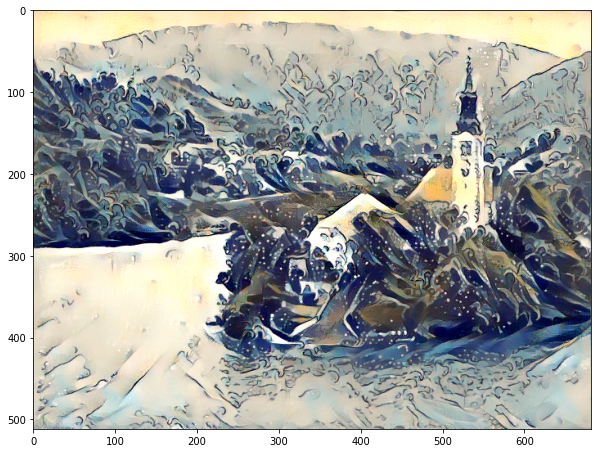

In [31]:
out_img_hr = postprocess_b(output_image.data[0].cpu().squeeze())

imshow(out_img_hr)
gcf().set_size_inches(10,10)